In [ ]:


!pip install shap lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=df04680ac0c85b4cec4decf5da02df875babd4cfd38159270e0bf67baa3a5810
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Checking for NaN and Inf values in features...
False
False
Checking for NaN and Inf values in targets...
False
False
Confirming no NaN or Inf values after imputation in features...
False
False
Confirming no NaN or Inf values after imputation in targets...
False
False
Epoch 1/1000
7/7 [==============================] - 2s 118ms/step - loss: 4.2067 - mae: 1.3815 - val_loss: 3.0049 - val_mae: 1.2733
Epoch 2/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.6375 - mae: 1.0718 - val_loss: 2.6463 - val_mae: 1.1963
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.0986 - mae: 0.9277 - val_loss: 2.4764 - val_mae: 1.1410
Epoch 4/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.7467 - mae: 0.8149 - val_loss: 2.3667 - val_mae: 1.0936
Epoch 5/1000
7/7 [==============================] - 0s 9ms/step - loss: 1.4943 - mae: 0.7380 - val_loss: 2.3118 - val_mae: 1.0668
Epoch 6/1000
7/7 [==============================] - 0s 10ms/step - loss: 1.3374 

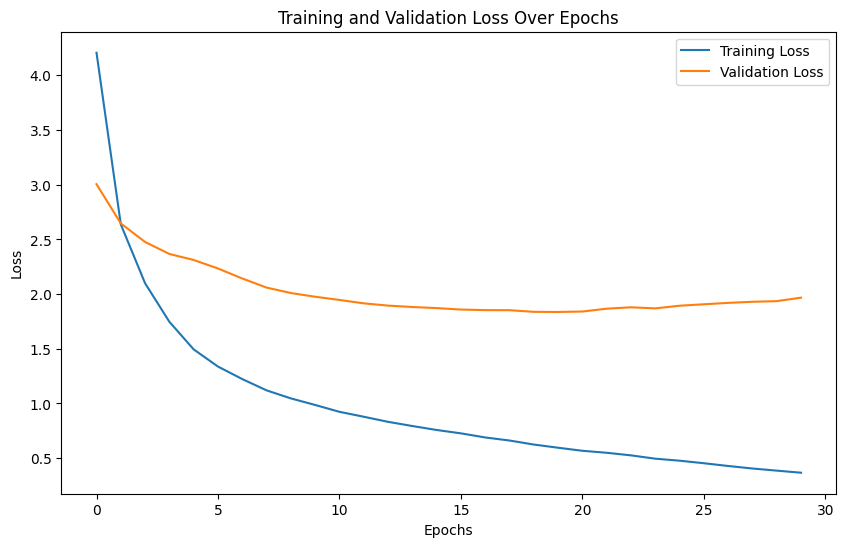

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import r2_score


# Set random seeds for reproducibility
np.random.seed(42)  # NumPy
random.seed(42)  # Python
tf.random.set_seed(42)  # TensorFlow

# Load your dataset
data_cleaned = pd.read_csv('/content/Padel_PCA_Z_Normalized_LCIA_Metrics_Dataset .csv')

# Define your target columns (LCIA metrics)
target_columns = [
    "GWP",
    "HTP",
    "MDP",
    "FETP",
    "PMFP",
    "TAP"
]

# The remaining columns will be the features
feature_columns = [col for col in data_cleaned.columns if col not in target_columns]

# Check for NaN values in features and target columns before imputation
print('Checking for NaN and Inf values in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Checking for NaN and Inf values in targets...')
print(data_cleaned[target_columns].isnull().any().any())
print(np.isinf(data_cleaned[target_columns]).any().any())

# Handle NaN and Inf values in features
data_cleaned[feature_columns] = data_cleaned[feature_columns].replace([np.inf, -np.inf], np.nan)
data_cleaned[feature_columns] = data_cleaned[feature_columns].fillna(data_cleaned[feature_columns].mean())

# Handle NaN and Inf values in targets
data_cleaned[target_columns] = data_cleaned[target_columns].replace([np.inf, -np.inf], np.nan)
data_cleaned[target_columns] = data_cleaned[target_columns].fillna(data_cleaned[target_columns].mean())

# Confirm that there are no NaN or Inf values after imputation
print('Confirming no NaN or Inf values after imputation in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Confirming no NaN or Inf values after imputation in targets...')
print(data_cleaned[target_columns].isnull().any().any())
print(np.isinf(data_cleaned[target_columns]).any().any())

# Splitting the dataset into features (X) and labels (y)
X = data_cleaned[feature_columns]
y = data_cleaned[target_columns]

# Splitting the dataset into training (60%), validation (20%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Neural Network Setup
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])  # Number of neurons equals the number of target variables
])

# Compile the model with mean squared error loss and mean absolute error metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size = 16, callbacks=[early_stopping], verbose=1)

# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation MAE: {val_mae}')

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Predictions for validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate R2 score for validation and test sets
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Validation R2 Score: {r2_val}')
print(f'Test R2 Score: {r2_test}')

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Glyph 9 (	) missing from current font.
Glyph 9 (	) missing from current font.


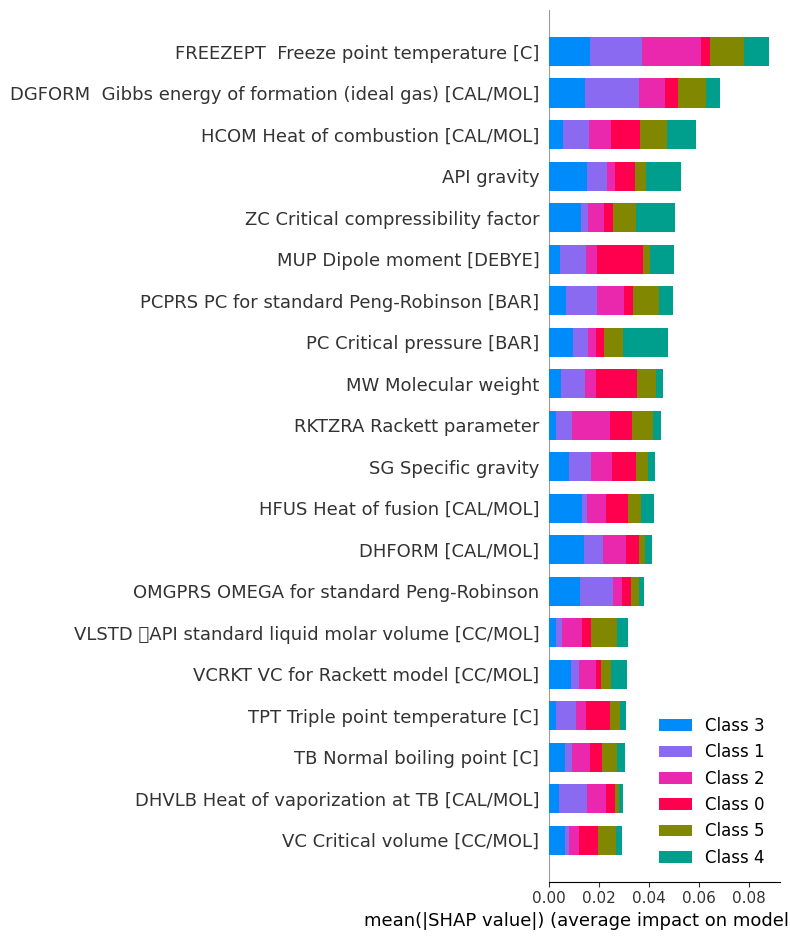

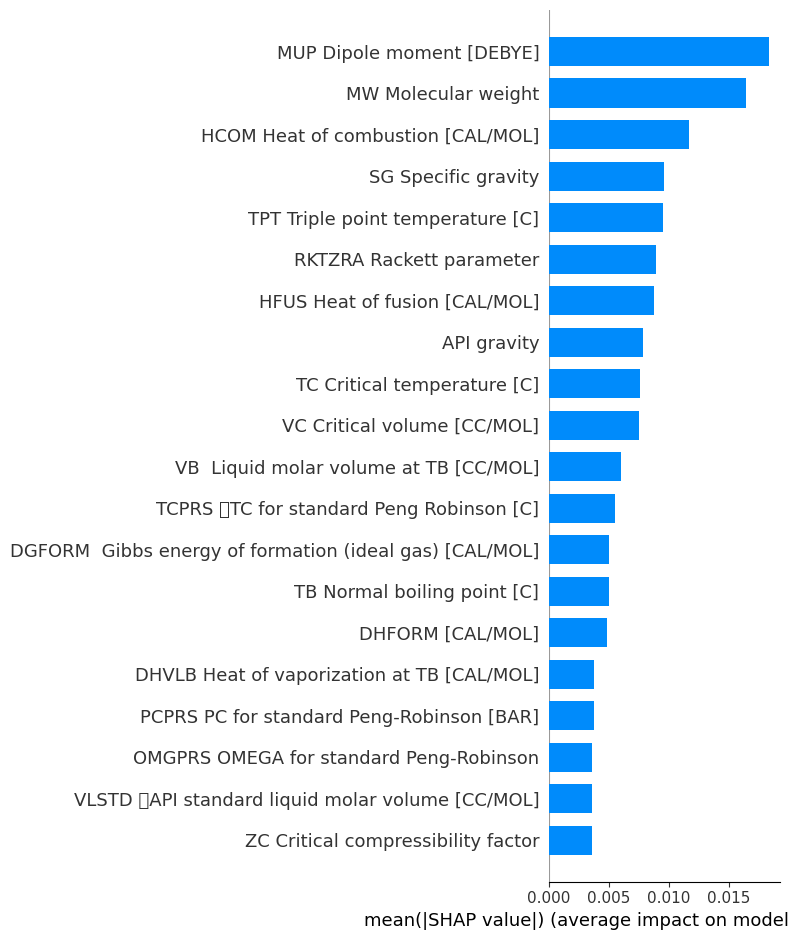

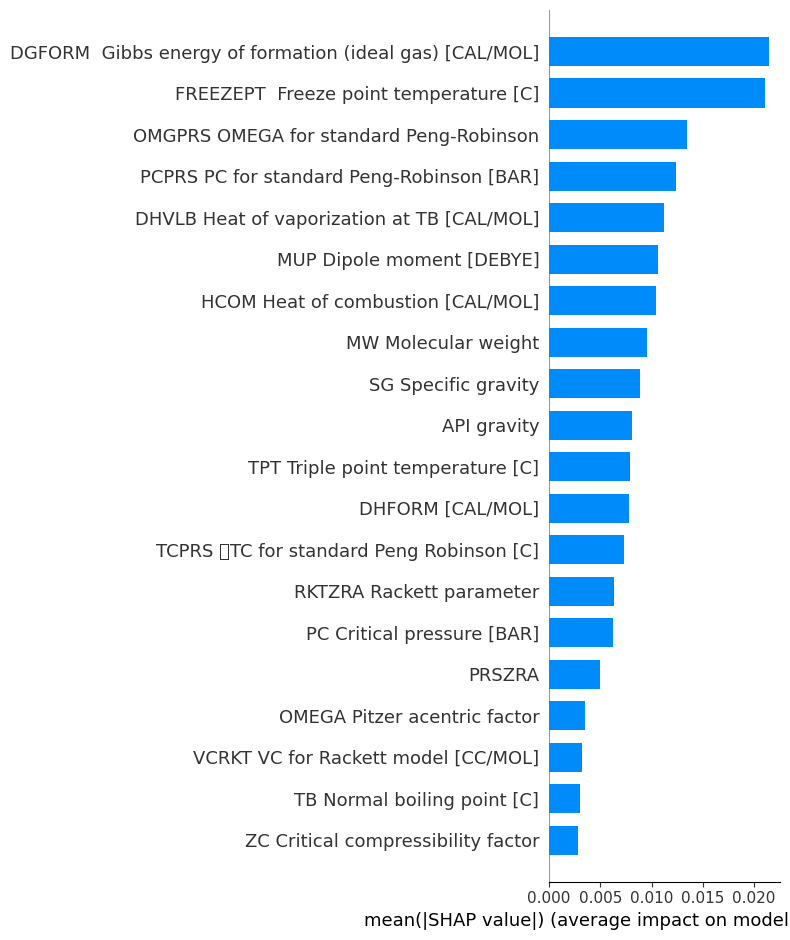

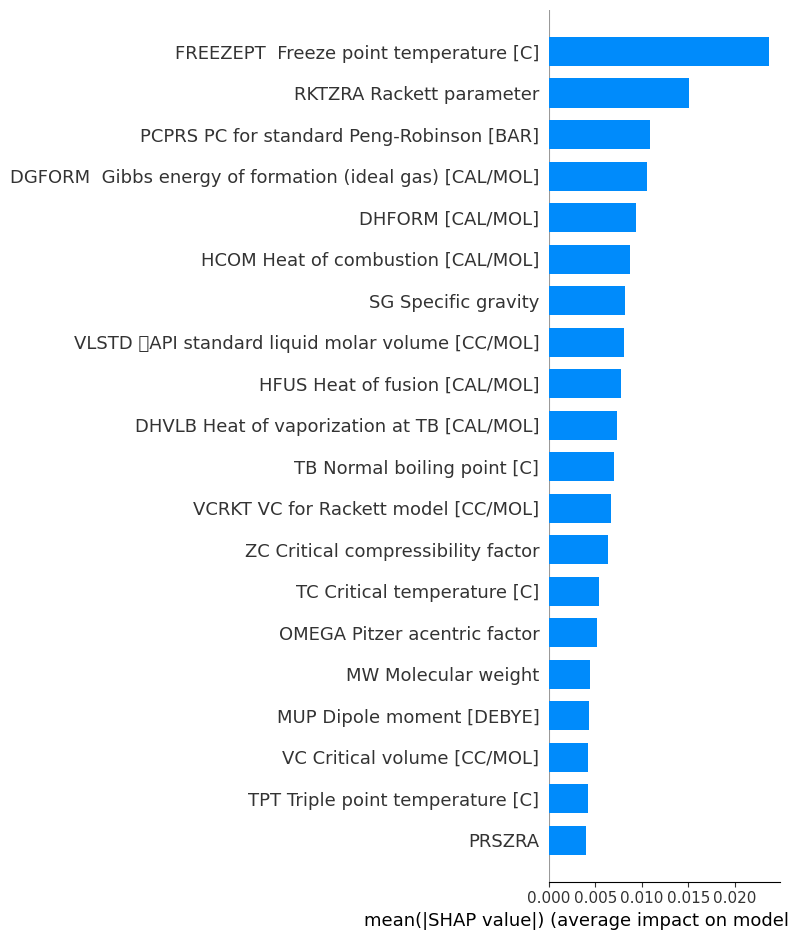

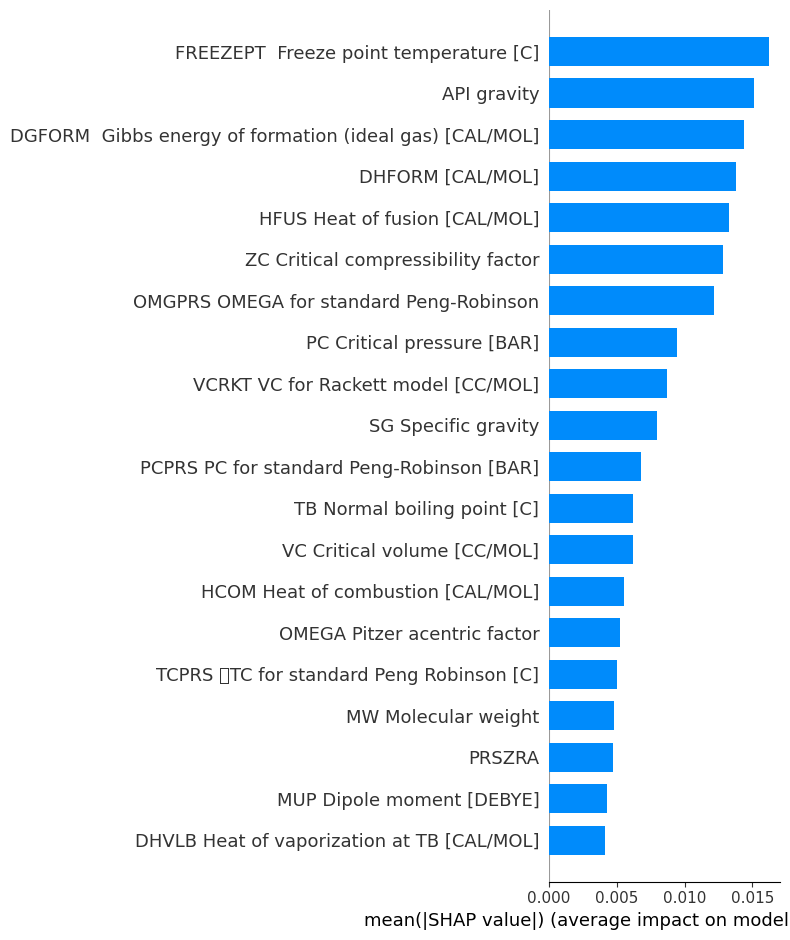

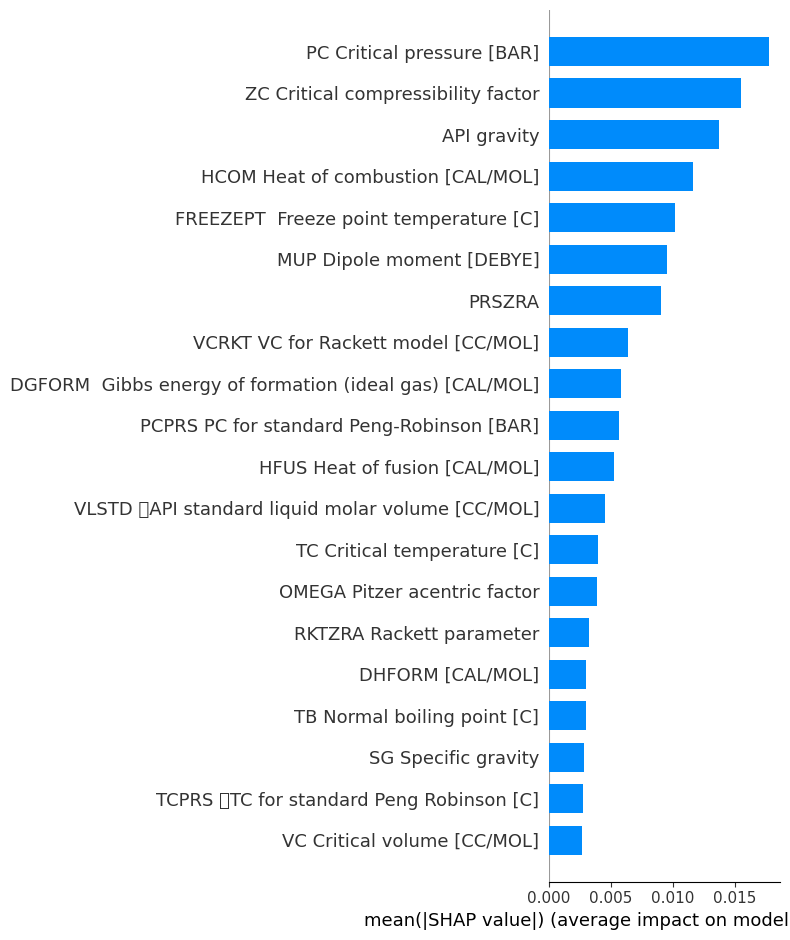

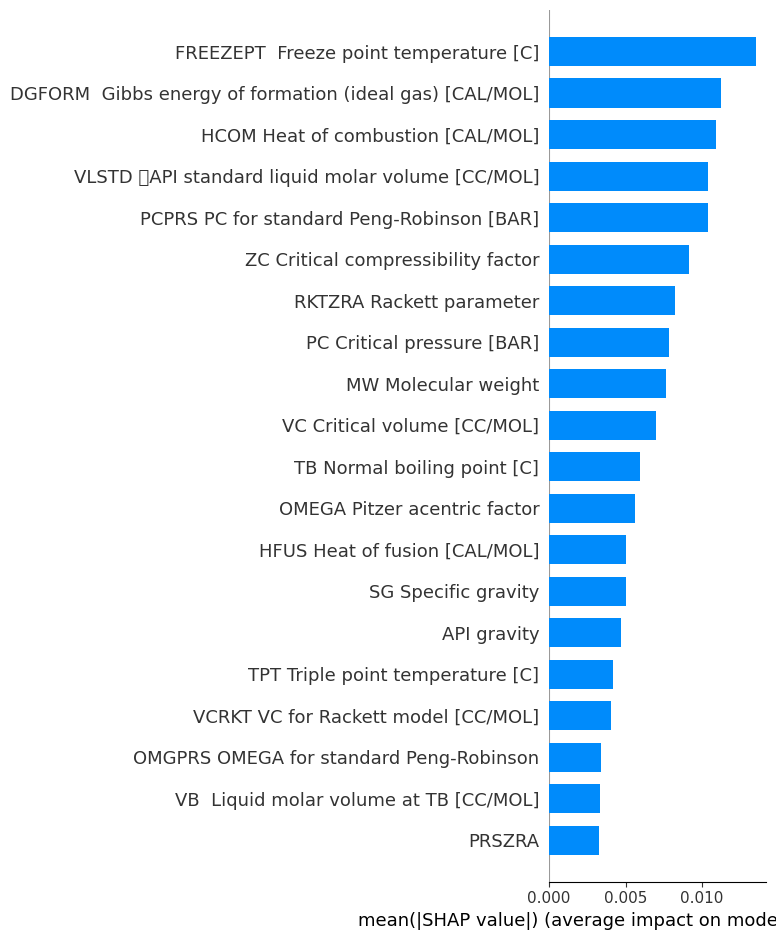

In [ ]:
# Initialize the SHAP explainer
explainer = shap.DeepExplainer(model, X_train.values)

# Calculate SHAP values - this may take some time
shap_values = explainer.shap_values(X_test.values)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, feature_names=feature_columns)

# For a detailed plot for each feature impact on the model, you can use the following:
for i in range(len(target_columns)):
    shap.summary_plot(shap_values[i], X_test, feature_names=feature_columns, plot_type="bar")

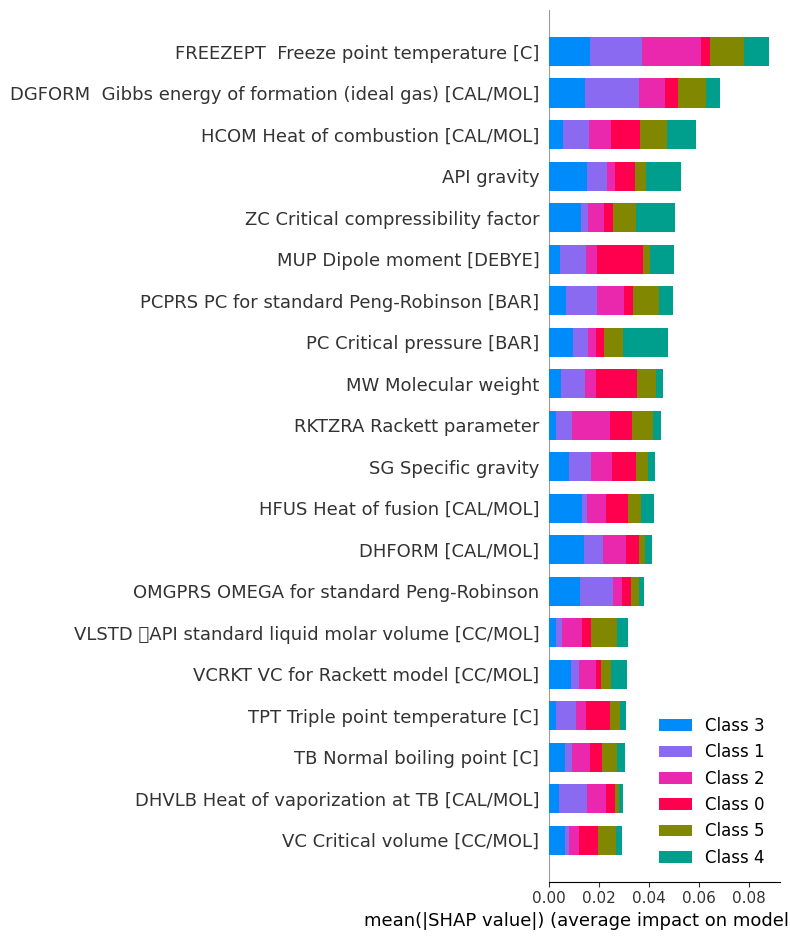

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=feature_columns)


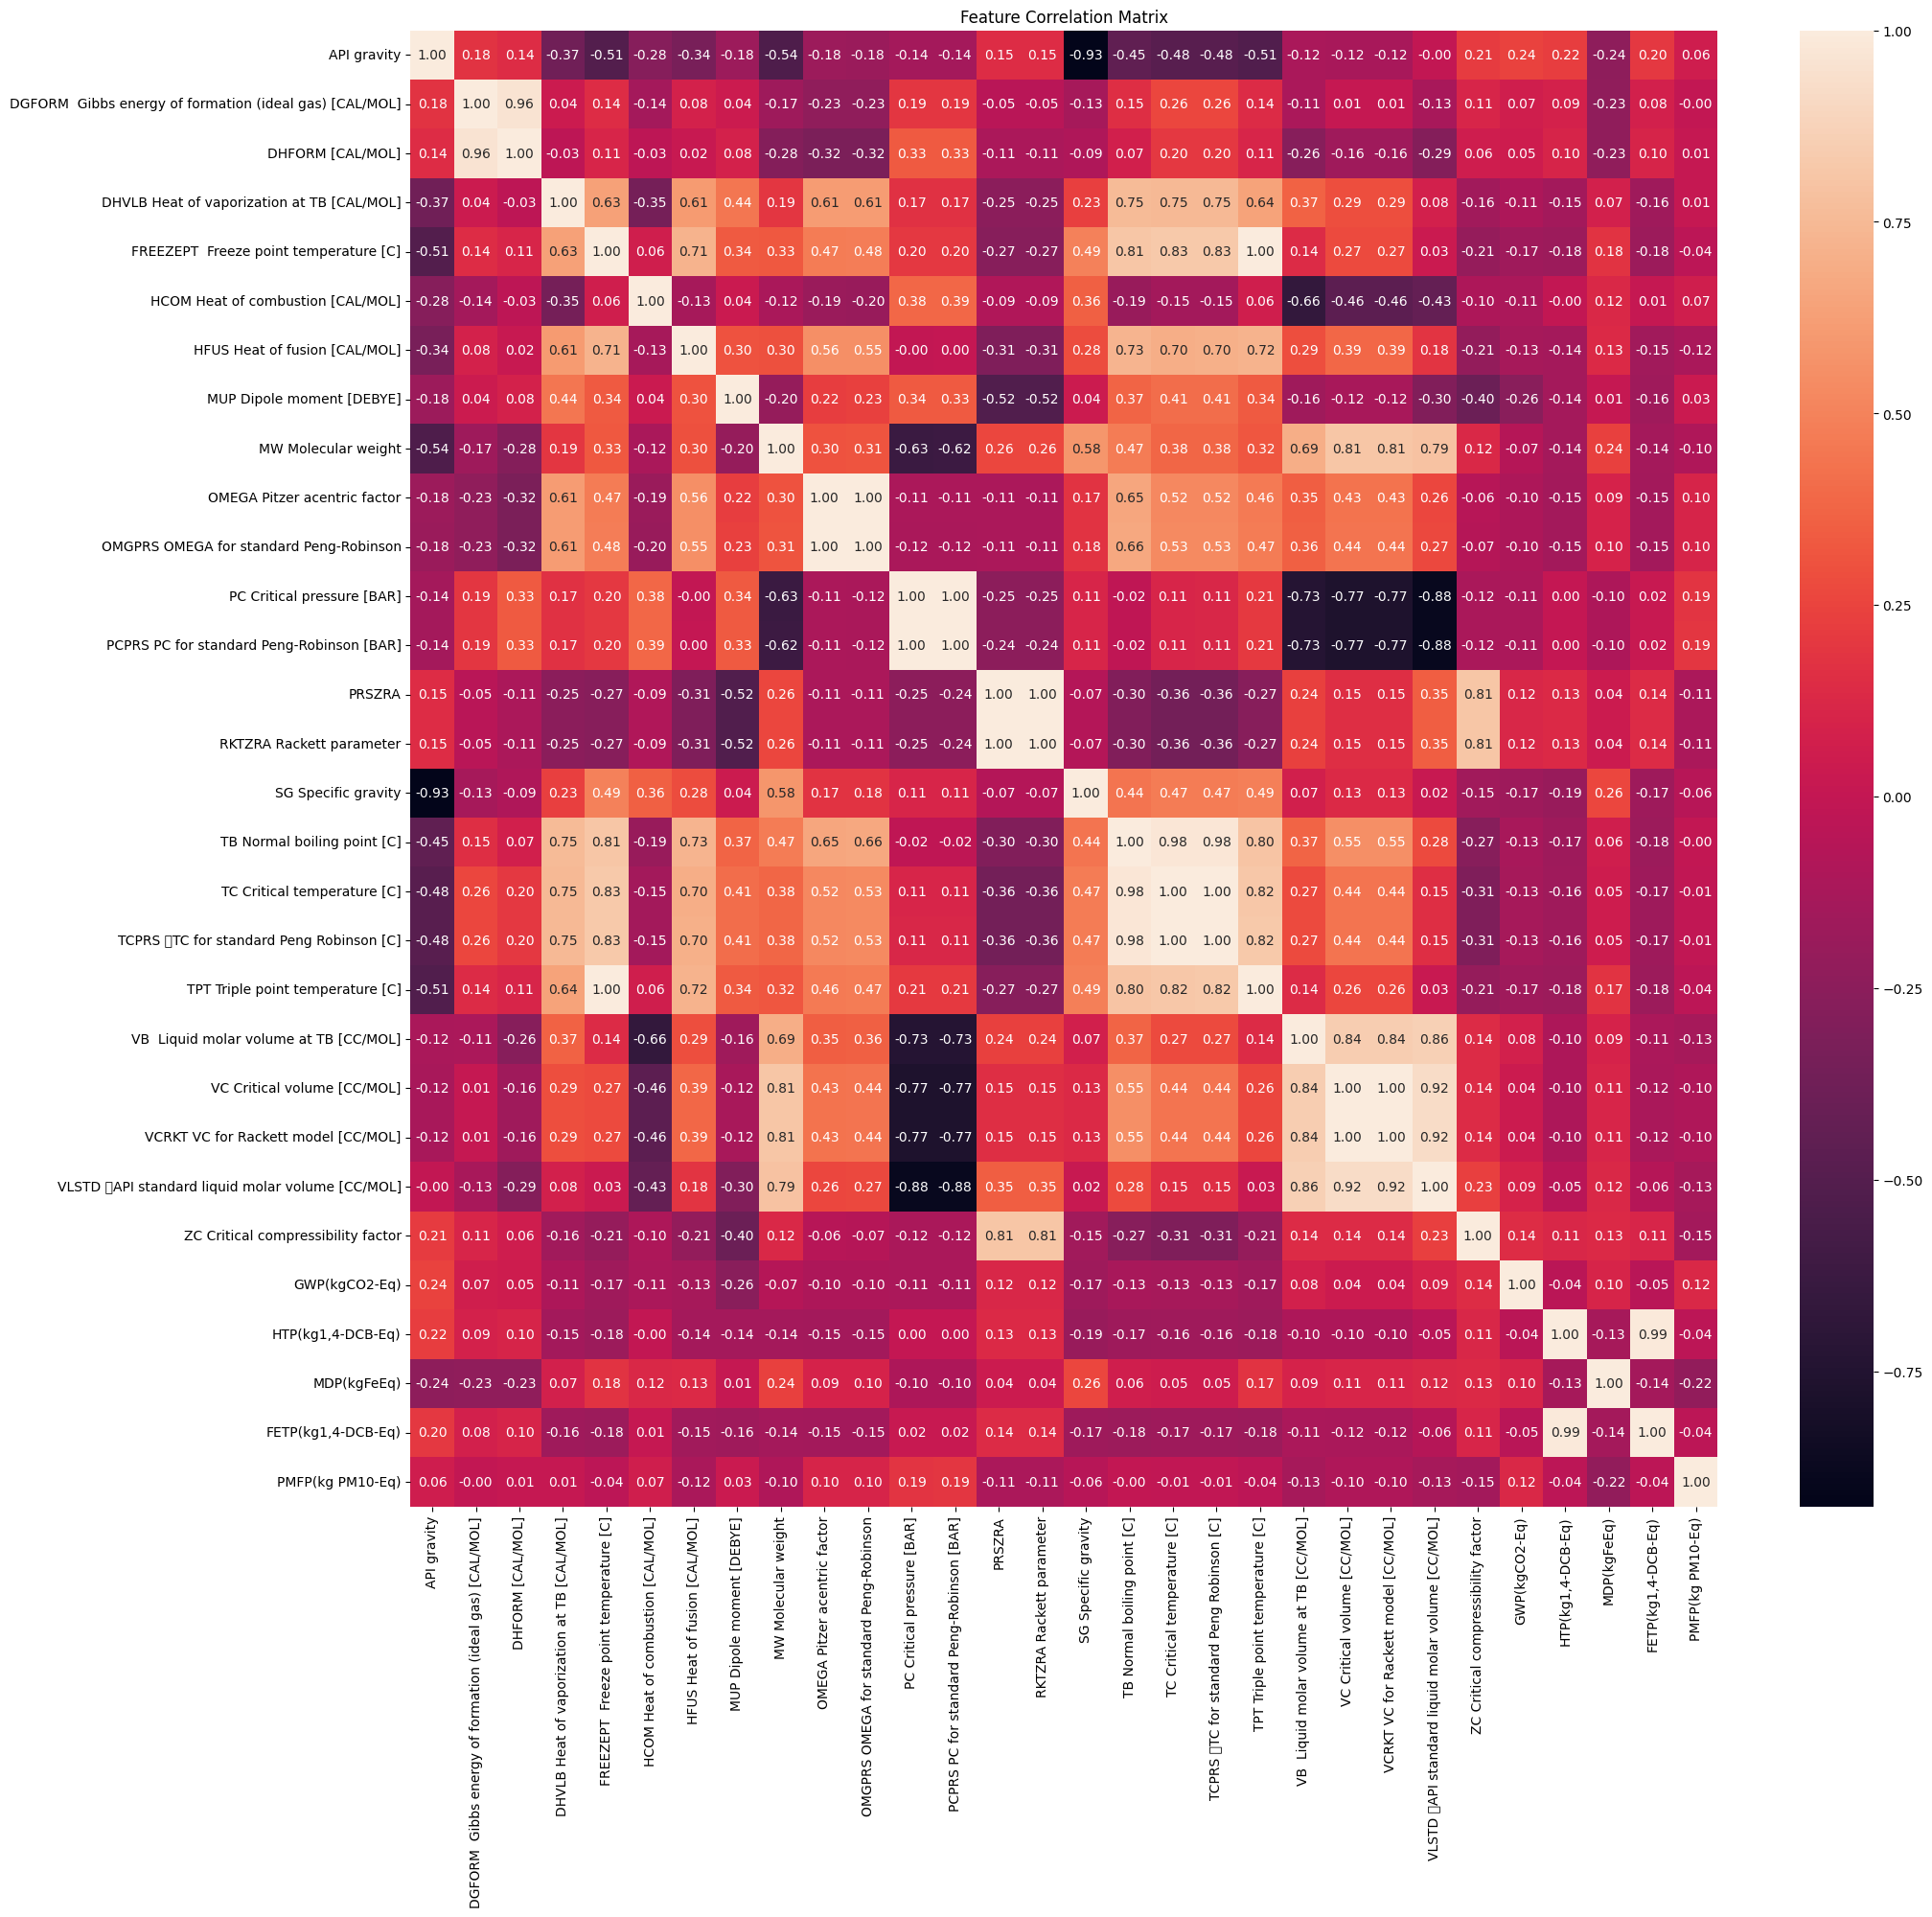

In [ ]:
import seaborn as sns

# Calculate correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(22, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# target_columns = [
#     "GWP(kgCO2-Eq)",
#     "HTP(kg1,4-DCB-Eq)",
#     "MDP(kgFeEq)",  # Note the trailing space
#     "FETP(kg1,4-DCB-Eq)",  # Note the trailing space
#     "PMFP(kg PM10-Eq)",  # Note the trailing space
#     "TAP(kgSO2-Eq)"  # Note the spaces
# ]

# BASELINE MODEL

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load your dataset
data_cleaned = pd.read_csv('/content/descriptors_seventeen_synthetic_data.csv')

# Define your target column (only one LCIA metric)
target_column = "GWP kgCO2-Eq"

# List of all LCIA impact metrics
lcia_metrics = ["GWP", "HTP", "MDP", "FETP", "PMFP", "TAP"]

# Exclude the target metric and other LCIA metrics from the feature columns
feature_columns = [col for col in data_cleaned.columns if col not in lcia_metrics or col == target_column]

# # Check for NaN values in features and target column before imputation
# print('Checking for NaN and Inf values in features...')
# print(data_cleaned[feature_columns].isnull().any().any())
# print(np.isinf(data_cleaned[feature_columns]).any().any())

# print('Checking for NaN and Inf values in target...')
# print(data_cleaned[target_column].isnull().any())
# print(np.isinf(data_cleaned[target_column]).any())

# # Handle NaN and Inf values in features
# data_cleaned[feature_columns] = data_cleaned[feature_columns].replace([np.inf, -np.inf], np.nan)
# data_cleaned[feature_columns] = data_cleaned[feature_columns].fillna(data_cleaned[feature_columns].mean())

# # Handle NaN and Inf values in target
# data_cleaned[target_column] = data_cleaned[target_column].replace([np.inf, -np.inf], np.nan)
# data_cleaned[target_column] = data_cleaned[target_column].fillna(data_cleaned[target_column].mean())

# # Confirm that there are no NaN or Inf values after imputation
# print('Confirming no NaN or Inf values after imputation in features...')
# print(data_cleaned[feature_columns].isnull().any().any())
# print(np.isinf(data_cleaned[feature_columns]).any().any())

# print('Confirming no NaN or Inf values after imputation in target...')
# print(data_cleaned[target_column].isnull().any())
# print(np.isinf(data_cleaned[target_column]).any())

# Splitting the dataset into features (X) and labels (y)
X = data_cleaned[feature_columns]
y = data_cleaned[target_column]

# Splitting the dataset into training (60%), validation (20%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Neural Network Setup
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Only one output neuron as we are predicting a single metric
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[early_stopping], verbose=1)

# Evaluation
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation MAE: {val_mae}')

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate R2 score
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Validation R2 Score: {r2_val}')
print(f'Test R2 Score: {r2_test}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

# Increased Depth Model

Checking for NaN and Inf values in features...
False
False
Checking for NaN and Inf values in target...
False
False
Confirming no NaN or Inf values after imputation in features...
False
False
Confirming no NaN or Inf values after imputation in target...
False
False
Epoch 1/1000
7/7 [==============================] - 2s 61ms/step - loss: 0.9486 - mae: 0.7547 - val_loss: 1.0796 - val_mae: 0.8565
Epoch 2/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.9038 - mae: 0.7451 - val_loss: 1.1054 - val_mae: 0.7510
Epoch 3/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.8966 - mae: 0.7204 - val_loss: 1.0946 - val_mae: 0.7928
Epoch 4/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.8656 - mae: 0.6816 - val_loss: 1.0995 - val_mae: 0.7899
Epoch 5/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.8483 - mae: 0.7020 - val_loss: 1.1031 - val_mae: 0.8063
Epoch 6/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.8240

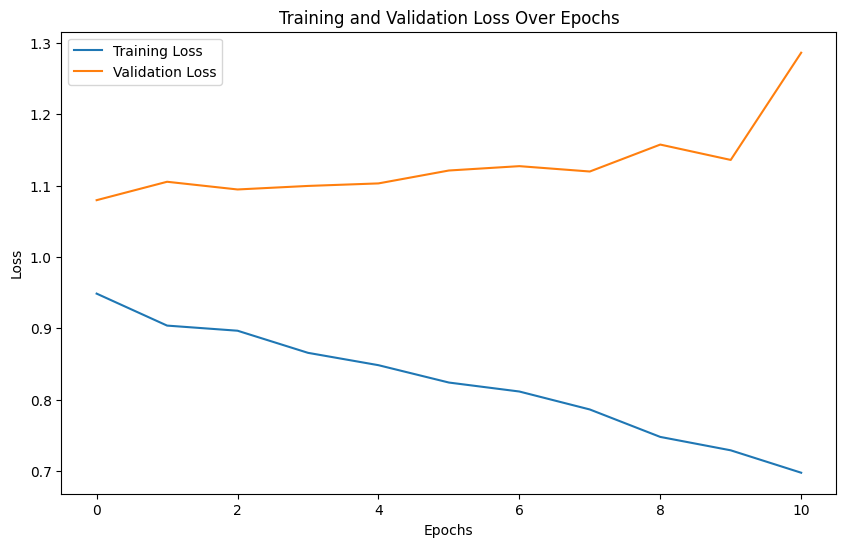

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load your dataset
data_cleaned = pd.read_csv('/content/TAP_thermodynamic_selected_features.csv')

# Define your target column (only one LCIA metric)
target_column = "TAP"

# The remaining columns will be the features
feature_columns = [col for col in data_cleaned.columns if col != target_column]

# Check for NaN values in features and target column before imputation
print('Checking for NaN and Inf values in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Checking for NaN and Inf values in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Handle NaN and Inf values in features
data_cleaned[feature_columns] = data_cleaned[feature_columns].replace([np.inf, -np.inf], np.nan)
data_cleaned[feature_columns] = data_cleaned[feature_columns].fillna(data_cleaned[feature_columns].mean())

# Handle NaN and Inf values in target
data_cleaned[target_column] = data_cleaned[target_column].replace([np.inf, -np.inf], np.nan)
data_cleaned[target_column] = data_cleaned[target_column].fillna(data_cleaned[target_column].mean())

# Confirm that there are no NaN or Inf values after imputation
print('Confirming no NaN or Inf values after imputation in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Confirming no NaN or Inf values after imputation in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Splitting the dataset into features (X) and labels (y)
X = data_cleaned[feature_columns]
y = data_cleaned[target_column]

# Splitting the dataset into training (60%), validation (20%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Neural Network Setup
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Only one output neuron as we are predicting a single metric
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[early_stopping], verbose=1)

# Evaluation
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation MAE: {val_mae}')

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate R2 score
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Validation R2 Score: {r2_val}')
print(f'Test R2 Score: {r2_test}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Complex Model

Checking for NaN and Inf values in features...
False
False
Checking for NaN and Inf values in target...
False
False
Confirming no NaN or Inf values after imputation in features...
False
False
Confirming no NaN or Inf values after imputation in target...
False
False
Epoch 1/1000
7/7 [==============================] - 2s 46ms/step - loss: 1.5770 - mae: 0.5102 - val_loss: 0.1739 - val_mae: 0.3447
Epoch 2/1000
7/7 [==============================] - 0s 12ms/step - loss: 1.5834 - mae: 0.4908 - val_loss: 0.1750 - val_mae: 0.3442
Epoch 3/1000
7/7 [==============================] - 0s 11ms/step - loss: 1.5589 - mae: 0.4858 - val_loss: 0.1624 - val_mae: 0.3339
Epoch 4/1000
7/7 [==============================] - 0s 14ms/step - loss: 1.5370 - mae: 0.4977 - val_loss: 0.1623 - val_mae: 0.3343
Epoch 5/1000
7/7 [==============================] - 0s 13ms/step - loss: 1.4943 - mae: 0.4931 - val_loss: 0.1481 - val_mae: 0.3181
Epoch 6/1000
7/7 [==============================] - 0s 12ms/step - loss: 1.4453

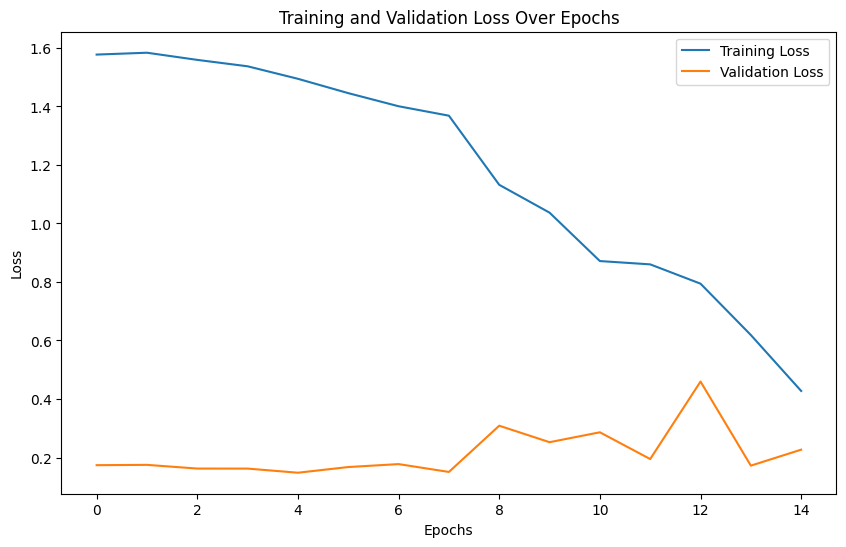

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load your dataset
data_cleaned = pd.read_csv('/content/TAP_thermodynamic_selected_features.csv')

# Define your target column (only one LCIA metric)
target_column = "TAP"

# The remaining columns will be the features
feature_columns = [col for col in data_cleaned.columns if col != target_column]

# Check for NaN values in features and target column before imputation
print('Checking for NaN and Inf values in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Checking for NaN and Inf values in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Handle NaN and Inf values in features
data_cleaned[feature_columns] = data_cleaned[feature_columns].replace([np.inf, -np.inf], np.nan)
data_cleaned[feature_columns] = data_cleaned[feature_columns].fillna(data_cleaned[feature_columns].mean())

# Handle NaN and Inf values in target
data_cleaned[target_column] = data_cleaned[target_column].replace([np.inf, -np.inf], np.nan)
data_cleaned[target_column] = data_cleaned[target_column].fillna(data_cleaned[target_column].mean())

# Confirm that there are no NaN or Inf values after imputation
print('Confirming no NaN or Inf values after imputation in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Confirming no NaN or Inf values after imputation in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Splitting the dataset into features (X) and labels (y)
X = data_cleaned[feature_columns]
y = data_cleaned[target_column]

# Splitting the dataset into training (60%), validation (20%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Neural Network Setup
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Only one output neuron as we are predicting a single metric
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[early_stopping], verbose=1)

# Evaluation
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation MAE: {val_mae}')

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate R2 score
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Validation R2 Score: {r2_val}')
print(f'Test R2 Score: {r2_test}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Increased Width

Checking for NaN and Inf values in features...
False
False
Checking for NaN and Inf values in target...
False
False
Confirming no NaN or Inf values after imputation in features...
False
False
Confirming no NaN or Inf values after imputation in target...
False
False
Epoch 1/1000
7/7 [==============================] - 3s 39ms/step - loss: 1.5739 - mae: 0.5167 - val_loss: 0.3799 - val_mae: 0.5242
Epoch 2/1000
7/7 [==============================] - 0s 9ms/step - loss: 1.5631 - mae: 0.4876 - val_loss: 0.1374 - val_mae: 0.3149
Epoch 3/1000
7/7 [==============================] - 0s 11ms/step - loss: 1.4900 - mae: 0.5029 - val_loss: 0.1845 - val_mae: 0.3494
Epoch 4/1000
7/7 [==============================] - 0s 12ms/step - loss: 1.4236 - mae: 0.4842 - val_loss: 0.2023 - val_mae: 0.3712
Epoch 5/1000
7/7 [==============================] - 0s 9ms/step - loss: 1.3378 - mae: 0.4859 - val_loss: 0.2000 - val_mae: 0.3564
Epoch 6/1000
7/7 [==============================] - 0s 12ms/step - loss: 1.2407 -

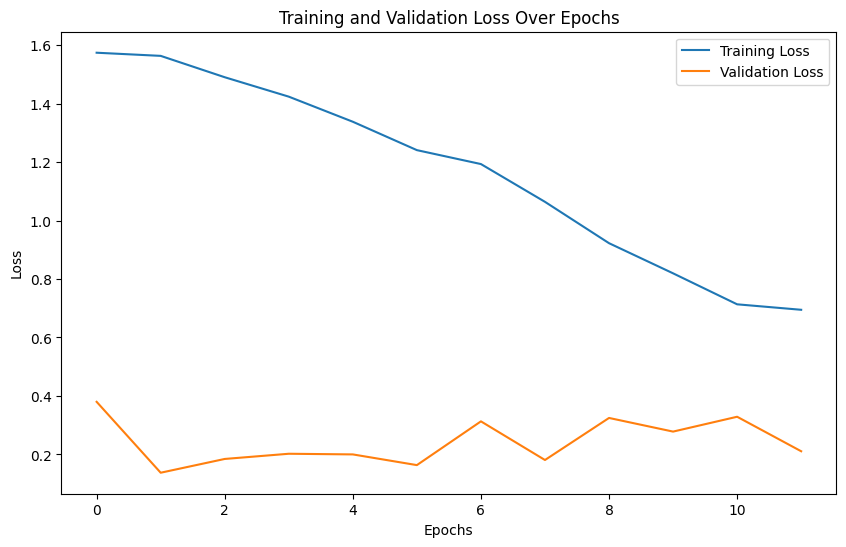

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load your dataset
data_cleaned = pd.read_csv('/content/TAP_thermodynamic_selected_features.csv')

# Define your target column (only one LCIA metric)
target_column = "TAP"

# The remaining columns will be the features
feature_columns = [col for col in data_cleaned.columns if col != target_column]

# Check for NaN values in features and target column before imputation
print('Checking for NaN and Inf values in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Checking for NaN and Inf values in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Handle NaN and Inf values in features
data_cleaned[feature_columns] = data_cleaned[feature_columns].replace([np.inf, -np.inf], np.nan)
data_cleaned[feature_columns] = data_cleaned[feature_columns].fillna(data_cleaned[feature_columns].mean())

# Handle NaN and Inf values in target
data_cleaned[target_column] = data_cleaned[target_column].replace([np.inf, -np.inf], np.nan)
data_cleaned[target_column] = data_cleaned[target_column].fillna(data_cleaned[target_column].mean())

# Confirm that there are no NaN or Inf values after imputation
print('Confirming no NaN or Inf values after imputation in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Confirming no NaN or Inf values after imputation in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Splitting the dataset into features (X) and labels (y)
X = data_cleaned[feature_columns]
y = data_cleaned[target_column]

# Splitting the dataset into training (60%), validation (20%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Neural Network Setup
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1)  # Only one output neuron as we are predicting a single metric
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[early_stopping], verbose=1)

# Evaluation
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation MAE: {val_mae}')

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate R2 score
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Validation R2 Score: {r2_val}')
print(f'Test R2 Score: {r2_test}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Decreased Complexity

Checking for NaN and Inf values in features...
False
False
Checking for NaN and Inf values in target...
False
False
Confirming no NaN or Inf values after imputation in features...
False
False
Confirming no NaN or Inf values after imputation in target...
False
False
Epoch 1/1000
7/7 [==============================] - 2s 37ms/step - loss: 1.5294 - mae: 0.4956 - val_loss: 0.1802 - val_mae: 0.3555
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 1.5060 - mae: 0.4832 - val_loss: 0.2090 - val_mae: 0.3723
Epoch 3/1000
7/7 [==============================] - 0s 11ms/step - loss: 1.4817 - mae: 0.4762 - val_loss: 0.1851 - val_mae: 0.3566
Epoch 4/1000
7/7 [==============================] - 0s 8ms/step - loss: 1.4709 - mae: 0.4754 - val_loss: 0.1677 - val_mae: 0.3425
Epoch 5/1000
7/7 [==============================] - 0s 10ms/step - loss: 1.4547 - mae: 0.4773 - val_loss: 0.1857 - val_mae: 0.3545
Epoch 6/1000
7/7 [==============================] - 0s 10ms/step - loss: 1.4353 -

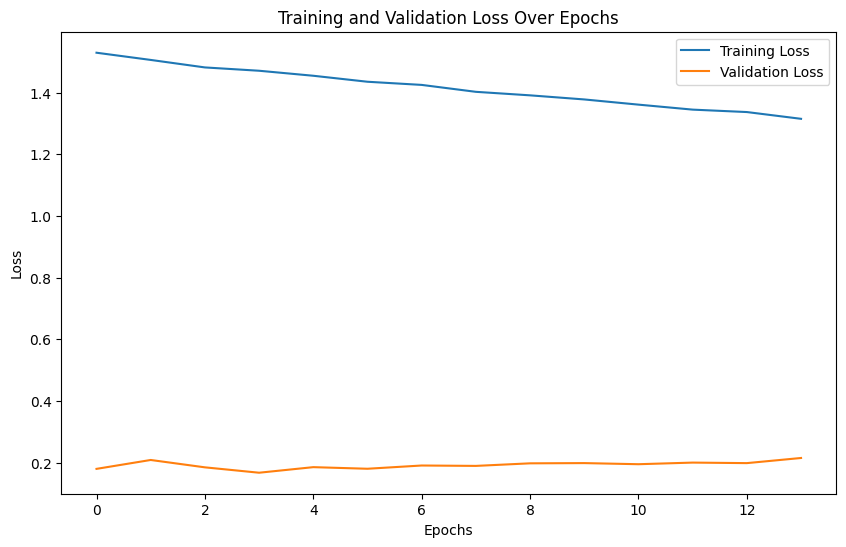

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load your dataset
data_cleaned = pd.read_csv('/content/TAP_thermodynamic_selected_features.csv')

# Define your target column (only one LCIA metric)
target_column = "TAP"

# The remaining columns will be the features
feature_columns = [col for col in data_cleaned.columns if col != target_column]

# Check for NaN values in features and target column before imputation
print('Checking for NaN and Inf values in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Checking for NaN and Inf values in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Handle NaN and Inf values in features
data_cleaned[feature_columns] = data_cleaned[feature_columns].replace([np.inf, -np.inf], np.nan)
data_cleaned[feature_columns] = data_cleaned[feature_columns].fillna(data_cleaned[feature_columns].mean())

# Handle NaN and Inf values in target
data_cleaned[target_column] = data_cleaned[target_column].replace([np.inf, -np.inf], np.nan)
data_cleaned[target_column] = data_cleaned[target_column].fillna(data_cleaned[target_column].mean())

# Confirm that there are no NaN or Inf values after imputation
print('Confirming no NaN or Inf values after imputation in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Confirming no NaN or Inf values after imputation in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Splitting the dataset into features (X) and labels (y)
X = data_cleaned[feature_columns]
y = data_cleaned[target_column]

# Splitting the dataset into training (60%), validation (20%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Neural Network Setup
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Only one output neuron as we are predicting a single metric
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[early_stopping], verbose=1)

# Evaluation
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation MAE: {val_mae}')

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate R2 score
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Validation R2 Score: {r2_val}')
print(f'Test R2 Score: {r2_test}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# FULL EXPERIMENT LOOP

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load your dataset
data_cleaned = pd.read_csv('/content/pca_transformed_with_targets.csv')

# Define your target column (only one LCIA metric)
target_column = "TAP"

# List of all LCIA impact metrics
lcia_metrics = ["GWP", "HTP", "MDP", "FETP", "PMFP", "TAP"]

# Exclude the target metric and other LCIA metrics from the feature columns
# Exclude all LCIA metrics from the feature columns
feature_columns = [col for col in data_cleaned.columns if col not in lcia_metrics]

# Now split the dataset into features (X) and the target (y)
X = data_cleaned[feature_columns]
y = data_cleaned[target_column]


# Check for NaN values in features and target column before imputation
print('Checking for NaN and Inf values in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Checking for NaN and Inf values in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Handle NaN and Inf values in features
data_cleaned[feature_columns] = data_cleaned[feature_columns].replace([np.inf, -np.inf], np.nan)
data_cleaned[feature_columns] = data_cleaned[feature_columns].fillna(data_cleaned[feature_columns].mean())

# Handle NaN and Inf values in target
data_cleaned[target_column] = data_cleaned[target_column].replace([np.inf, -np.inf], np.nan)
data_cleaned[target_column] = data_cleaned[target_column].fillna(data_cleaned[target_column].mean())

# Confirm that there are no NaN or Inf values after imputation
print('Confirming no NaN or Inf values after imputation in features...')
print(data_cleaned[feature_columns].isnull().any().any())
print(np.isinf(data_cleaned[feature_columns]).any().any())

print('Confirming no NaN or Inf values after imputation in target...')
print(data_cleaned[target_column].isnull().any())
print(np.isinf(data_cleaned[target_column]).any())

# Splitting the dataset into features (X) and labels (y)
X = data_cleaned[feature_columns]
y = data_cleaned[target_column]

# Splitting the dataset into training (60%), validation (20%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define different architectures to test
architectures = {
    '3_layers': [128, 64, 32],
    '4_layers': [256, 128, 64, 32],
    '5_layers': [512, 256, 128, 64, 32],
    '3_layers_same': [256, 256, 256],
    '2_layers': [64, 32]
}

# Store results
results = []

# Loop over the architectures
for name, layers in architectures.items():
    # Neural Network Setup
    model = Sequential()
    for layer_size in layers:
        if model.layers:  # If not the first layer, don't specify input_shape
            model.add(Dense(layer_size, activation='relu'))
        else:  # For the first layer, specify the input_shape
            model.add(Dense(layer_size, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mean_squared_error',
                  metrics=['mae', 'mse'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=1000, batch_size=16,
                        callbacks=[early_stopping],
                        verbose=1)

    # Evaluation
    val_metrics = model.evaluate(X_val, y_val, verbose=0)
    test_metrics = model.evaluate(X_test, y_test, verbose=0)

    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Calculate R2 score
    r2_val = r2_score(y_val, y_val_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Save results
    results.append({
        'experiment': name,
        'val_mae': val_metrics[1],
        'val_mse': val_metrics[2],
        'val_r2': r2_val,
        'test_mae': test_metrics[1],
        'test_mse': test_metrics[2],
        'test_r2': r2_test
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('GWP_model_performance_results.csv', index=False)


Checking for NaN and Inf values in features...
False
False
Checking for NaN and Inf values in target...
False
False
Confirming no NaN or Inf values after imputation in features...
False
False
Confirming no NaN or Inf values after imputation in target...
False
False
Epoch 1/1000
7/7 [==============================] - 3s 57ms/step - loss: 1.0309 - mae: 0.8242 - mse: 1.0309 - val_loss: 1.0957 - val_mae: 0.7496 - val_mse: 1.0957
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.8671 - mae: 0.6883 - mse: 0.8671 - val_loss: 1.1321 - val_mae: 0.7730 - val_mse: 1.1321
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.8259 - mae: 0.6845 - mse: 0.8259 - val_loss: 1.1366 - val_mae: 0.7940 - val_mse: 1.1366
Epoch 4/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.7851 - mae: 0.6668 - mse: 0.7851 - val_loss: 1.1610 - val_mae: 0.7940 - val_mse: 1.1610
Epoch 5/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.7550 - mae

In [ ]:
# Optionally, save the results to a CSV file
results_df.to_csv('m_model_performance_results.csv', index=True)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


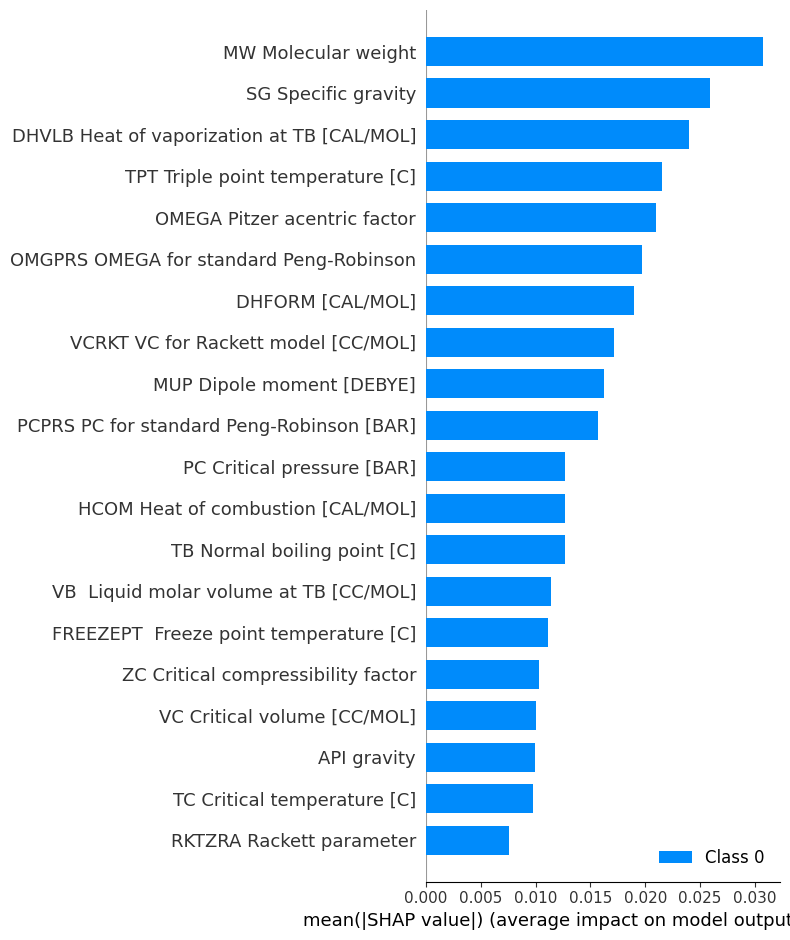

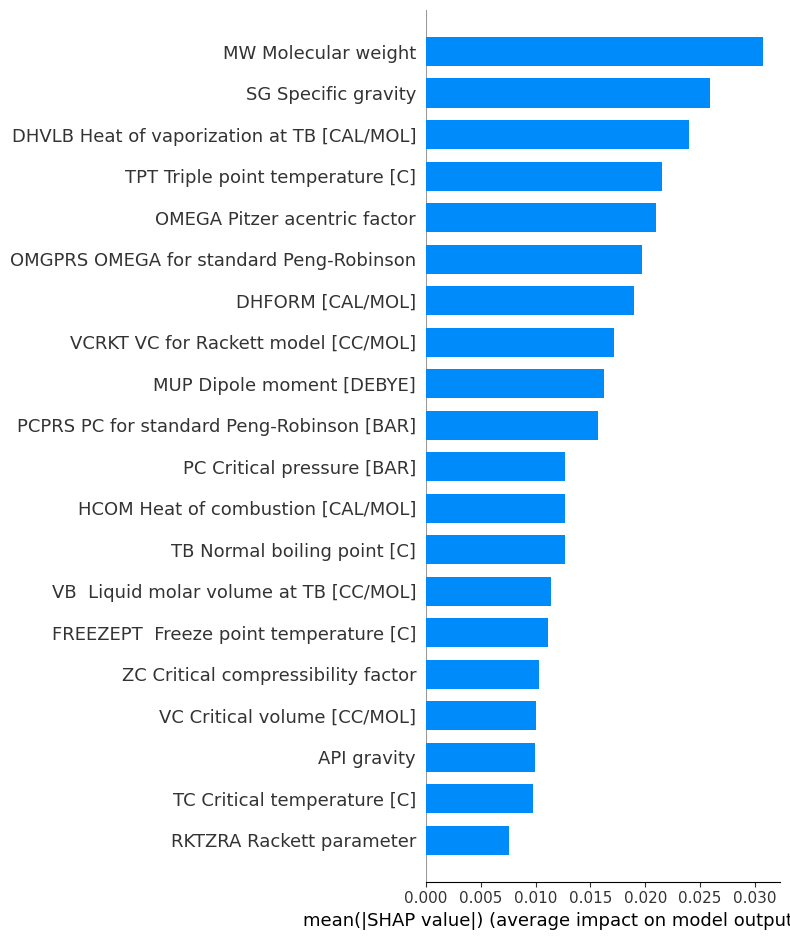

IndexError: list index out of range

In [ ]:
# Initialize the SHAP explainer
import shap
explainer = shap.DeepExplainer(model, X_train.values)

# Calculate SHAP values - this may take some time
shap_values = explainer.shap_values(X_test.values)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, feature_names=feature_columns)

# For a detailed plot for each feature impact on the model, you can use the following:
for i in range(len(target_column)):
    shap.summary_plot(shap_values[i], X_test, feature_names=feature_columns, plot_type="bar")

In [ ]:
# Create a Lime Explainer
import lime
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['GWP'],
    mode='regression'
)

# Explain the prediction for a single instance
i = 10  # Index of the instance to explain
exp = explainer.explain_instance(X_test.iloc[i], model.predict, num_features=10)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)

157/157 [==============================] - 0s 2ms/step
